## AutoEncoder 구현

In [31]:
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from torch import nn, optim
from torchvision import transforms, datasets

In [32]:
# 하이퍼파라미터
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [59]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    root      = '../PaperWithCode/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

testset = datasets.FashionMNIST(
    root = '../PaperWithCode/',
    train = False,
    download= True,
    transform=transforms.ToTensor()
)

test_loader = torch.utils.data.DataLoader(
    dataset = testset,
    batch_size = BATCH_SIZE,
    shuffle = True, 
    num_workers = 2
)

In [34]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [7]:
autoencoder = Autoencoder().to(DEVICE)                              #DEVICE로 모델전달 
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)    #Optimizer : Adam
criterion = nn.MSELoss()                                            #loss function : MSE 

In [8]:
view_data = trainset.data[:5].view(-1, 28*28) # 원본 이미지를 시각화 하기 (첫번째 열)
view_data = view_data.type(torch.FloatTensor)/255. #FloatTensor로 전환 후 0과 1사이의 값을 갖기 위해 255.0 으로 나눔

In [35]:
def train(autoencoder, train_loader):
    autoencoder.train()             # train mode
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)     
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y) # 원본과 디코딩 결과의 차이
        optimizer.zero_grad()        # 가중치 초기화
        loss.backward()              # 역전파
        optimizer.step()             # 가중치 갱신

[Epoch 1]


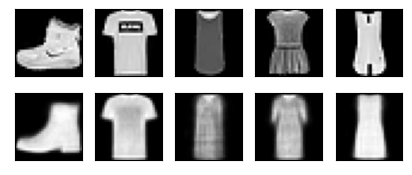

[Epoch 2]


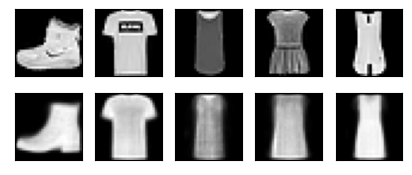

[Epoch 3]


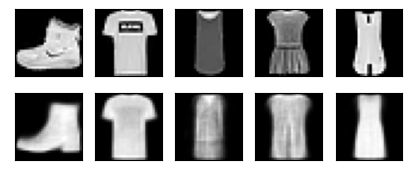

[Epoch 4]


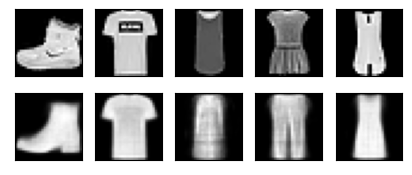

[Epoch 5]


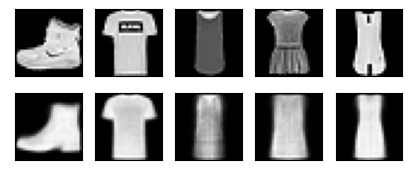

[Epoch 6]


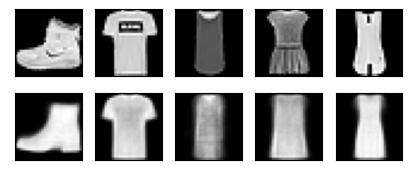

[Epoch 7]


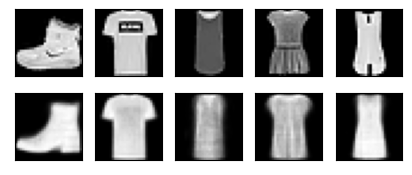

[Epoch 8]


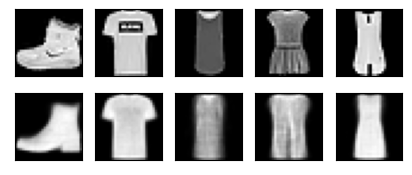

[Epoch 9]


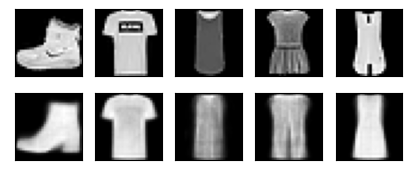

[Epoch 10]


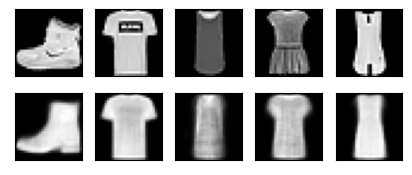

In [50]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)    # 모델 훈련

    test_x = view_data.to(DEVICE)         # view_data를 test data로 사용하기 위해 cuda에 올림. 
    _, decoded_data = autoencoder(test_x) # decoded_data를 output으로 받음, encoded data를 필요없기에 _으로 버림. 

    
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.detach().numpy()[i],(28, 28)) #.detach() : 기존 Tensor에서 gradient 전파가 안되는 텐서 생성(일종의 복사)
        a[0][i].imshow(img, cmap='gray')                         #imshow -> 원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림, 원하는 크기의 행렬을 만들어서 각 칸을 원하는 색으로 채우는 것 
        a[0][i].set_xticks(())                                   #set.xticks() 안에 공백으로 처리
        a[0][i].set_yticks(())                                   #set.yticks() 안에 공백으로 처리

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").detach().numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()

## 잠재변수를 3D 플롯으로 시각화


In [17]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

In [18]:
view_data = trainset.data[:200].view(-1, 28*28)     #trainset에서 200개 -> view_data 
view_data = view_data.type(torch.FloatTensor)/255.  #view_data : FloatTensor로 전환 후 pixel 값으로 정규화
test_x = view_data.to(DEVICE)                       # to cuda
encoded_data, _ = autoencoder(test_x)                  
encoded_data = encoded_data.to("cpu")

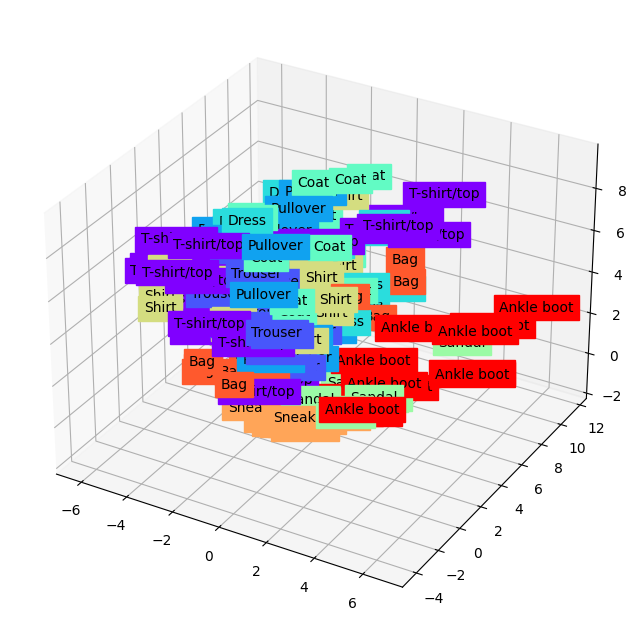

In [40]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig, ax =plt.subplots(figsize=(10,8), subplot_kw={"projection":"3d"})

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data()[:, 2].numpy()

labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

## Noise 추가 후 Reconstruction

In [54]:
#noise는 img사이즈와 동일한 random(0~1사이값*0.2)로 설정 후 기존이미지에 더함
def add_noise(img):  
   noise = torch.randn(img.size())*0.2
   noisy_img = img+noise
   return noisy_img

In [55]:
def train(autoencoder, train_loader):
    autoencoder.train()
    mean_loss = 0
    for step, (x, label) in enumerate(train_loader): 
        x = add_noise(x)   #노이즈 추가
        x = x.view(-1,28*28).to(DEVICE)
        y = x.view(-1,28*28).to(DEVICE)
        label = label.to(DEVICE)
        
        encoded, decoded = autoencoder(x)
        
        loss = criterion(decoded,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
        
    return mean_loss / len(train_loader)

In [57]:
for epoch in range(1, EPOCH+10):
    loss = train(autoencoder, train_loader)
    print("epoch : {} , loss {} ".format(epoch, loss))

epoch : 1 , loss 0.061089605827734414 
epoch : 2 , loss 0.06108804908531434 
epoch : 3 , loss 0.0609644604588686 
epoch : 4 , loss 0.06103734068794927 
epoch : 5 , loss 0.06110602155772608 
epoch : 6 , loss 0.0611065047612386 
epoch : 7 , loss 0.06117699683300341 
epoch : 8 , loss 0.06119569094339286 
epoch : 9 , loss 0.06111318564840725 
epoch : 10 , loss 0.06107660458842193 
epoch : 11 , loss 0.06102327168829787 
epoch : 12 , loss 0.06106090246995629 
epoch : 13 , loss 0.061043396663627646 
epoch : 14 , loss 0.06110170720689205 
epoch : 15 , loss 0.06103458557365291 
epoch : 16 , loss 0.06094934506568192 
epoch : 17 , loss 0.06105287318656058 
epoch : 18 , loss 0.06098160503515557 
epoch : 19 , loss 0.061163874918908706 


In [60]:
sample_data = testset.data[0].view(-1,28*28)  #test를 위한 sample_data
sampe_data = sample_data.type(torch.FloatTensor)/255.

In [62]:
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

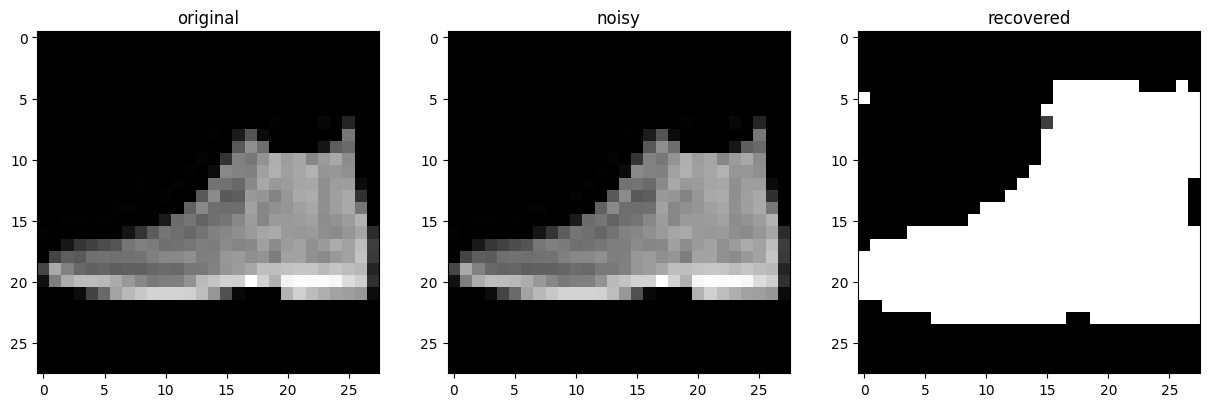

In [66]:
figure, axes = plt.subplots(1, 3, figsize=(15, 15))

original_img = np.reshape(original_x.to("cpu").data.numpy(), (28,28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(),(28,28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(),(28,28))

axes[0].set_title('original')
axes[0].imshow(original_img, cmap='gray')
axes[1].set_title('noisy')
axes[1].imshow(noisy_img,cmap='gray')
axes[2].set_title('recovered')
axes[2].imshow(recovered_img,cmap='gray')